In [3]:
!pip install -q tensorboard wandb imageio scipy scikit-learn

# **Objective:**
The primary objective of this assignment is to engineer a sophisticated deep generative model—specifically an Improved Conditional GAN—that goes beyond basic architectures to synthesize high-quality, novel data from a learned distribution. By integrating Spectral Normalization for training stability and a Conditional Twist for class-specific control, you are demonstrating the ability to address common generative failures like mode collapse while providing a practical tool for tasks such as synthetic data augmentation. The project evaluates your technical proficiency in designing complex neural networks, your analytical rigor in using quantitative metrics like FID scores, and your creative capacity to adapt state-of-the-art research into a functional, reproducible deep learning pipeline.

# **Configuration**

In [4]:
import torch
from dataclasses import dataclass, field
from typing import List, Optional

@dataclass
class Config:
    """All hyperparameters in one place"""
    # Model
    latent_dim: int = 100
    num_classes: int = 10
    embedding_dim: int = 50
    g_channels: List[int] = field(default_factory=lambda: [512, 256, 128, 64])
    d_channels: List[int] = field(default_factory=lambda: [64, 128, 256, 512])
    image_size: int = 32
    image_channels: int = 3

    # Training
    batch_size: int = 128
    epochs: int = 100  # Reduced for Colab
    lr_generator: float = 0.0002
    lr_discriminator: float = 0.0002
    beta1: float = 0.5
    beta2: float = 0.999
    real_label_smoothing: float = 0.9
    fake_label_smoothing: float = 0.1

    # Logging
    sample_interval: int = 500
    checkpoint_interval: int = 10

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

# CIFAR-10 class names
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def get_class_index(class_name: str) -> int:
    """Get class index from name"""
    return CIFAR10_CLASSES.index(class_name.lower())

# Create config
config = Config()
print(f"Training on: {config.device}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.epochs}")

Training on: cuda
Batch size: 128
Epochs: 100


# **Model Definitions**

In [5]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
from typing import List


class ConditionalBatchNorm2d(nn.Module):
    """Conditional Batch Normalization - learns class-specific scale and shift"""

    def __init__(self, num_features: int, num_classes: int):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)

        self.gamma_embed = nn.Embedding(num_classes, num_features)
        self.beta_embed = nn.Embedding(num_classes, num_features)

        nn.init.ones_(self.gamma_embed.weight)
        nn.init.zeros_(self.beta_embed.weight)

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        out = self.bn(x)
        gamma = self.gamma_embed(labels).view(-1, self.num_features, 1, 1)
        beta = self.beta_embed(labels).view(-1, self.num_features, 1, 1)
        return gamma * out + beta


class GeneratorBlock(nn.Module):
    """Transposed convolution block for upsampling"""

    def __init__(self, in_channels: int, out_channels: int, num_classes: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = ConditionalBatchNorm2d(out_channels, num_classes)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x, labels)
        x = self.activation(x)
        return x


class Generator(nn.Module):
    """
    Conditional DCGAN Generator

    Takes latent vector z and class label, produces class-conditional image.
    """

    def __init__(
        self,
        latent_dim: int = 100,
        num_classes: int = 10,
        embedding_dim: int = 50,
        channels: List[int] = None,
        image_channels: int = 3
    ):
        super().__init__()

        if channels is None:
            channels = [512, 256, 128, 64]

        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.init_size = 4

        # Class embedding
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # Project to initial feature map
        self.project = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, channels[0] * self.init_size * self.init_size),
            nn.BatchNorm1d(channels[0] * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        # Upsampling blocks: 4→8→16→32
        self.blocks = nn.ModuleList()
        in_ch = channels[0]
        for i in range(3):
            out_ch = channels[min(i + 1, len(channels) - 1)]
            self.blocks.append(GeneratorBlock(in_ch, out_ch, num_classes))
            in_ch = out_ch

        # Final conv
        self.final = nn.Sequential(
            nn.Conv2d(in_ch, image_channels, 3, 1, 1),
            nn.Tanh()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, z: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        label_embed = self.label_embedding(labels)
        x = torch.cat([z, label_embed], dim=1)
        x = self.project(x)
        x = x.view(-1, 512, self.init_size, self.init_size)

        for block in self.blocks:
            x = block(x, labels)

        return self.final(x)

    def sample(self, num_samples: int, labels=None, device=None):
        """Generate samples with optional class specification"""
        if device is None:
            device = next(self.parameters()).device

        z = torch.randn(num_samples, self.latent_dim, device=device)

        if labels is None:
            labels = torch.randint(0, self.num_classes, (num_samples,), device=device)
        elif isinstance(labels, int):
            labels = torch.full((num_samples,), labels, dtype=torch.long, device=device)
        elif isinstance(labels, str):
            labels = torch.full((num_samples,), get_class_index(labels), dtype=torch.long, device=device)
        else:
            labels = labels.to(device)

        return self.forward(z, labels)


class DiscriminatorBlock(nn.Module):
    """Conv block with spectral normalization"""

    def __init__(self, in_channels: int, out_channels: int, use_bn: bool = True):
        super().__init__()
        self.conv = spectral_norm(nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=not use_bn))
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.bn(self.conv(x)))


class Discriminator(nn.Module):
    """
    Conditional DCGAN Discriminator with Spectral Normalization

    Uses spectral_norm on all conv layers for training stability.
    """

    def __init__(
        self,
        num_classes: int = 10,
        embedding_dim: int = 50,
        channels: List[int] = None,
        image_channels: int = 3,
        image_size: int = 32
    ):
        super().__init__()

        if channels is None:
            channels = [64, 128, 256, 512]

        self.num_classes = num_classes
        self.image_size = image_size

        # Label embedding projected to spatial
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        self.label_project = spectral_norm(nn.Linear(embedding_dim, image_size * image_size))

        # Conv blocks (input = image + label channel)
        in_ch = image_channels + 1
        self.blocks = nn.ModuleList()

        for i, out_ch in enumerate(channels):
            self.blocks.append(DiscriminatorBlock(in_ch, out_ch, use_bn=(i > 0)))
            in_ch = out_ch

        # Final classifier
        final_size = image_size // (2 ** len(channels))
        self.classifier = nn.Sequential(
            spectral_norm(nn.Conv2d(channels[-1], 1, final_size, 1, 0)),
            nn.Flatten(),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) and hasattr(m, 'weight'):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d) and m.weight is not None:
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

    def forward(self, images: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        batch_size = images.size(0)

        label_embed = self.label_embedding(labels)
        label_map = self.label_project(label_embed).view(batch_size, 1, self.image_size, self.image_size)

        x = torch.cat([images, label_map], dim=1)

        for block in self.blocks:
            x = block(x)

        return self.classifier(x).squeeze()

    def get_feature(self, images: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """Get intermediate features for t-SNE"""
        batch_size = images.size(0)
        label_embed = self.label_embedding(labels)
        label_map = self.label_project(label_embed).view(batch_size, 1, self.image_size, self.image_size)
        x = torch.cat([images, label_map], dim=1)

        for block in self.blocks:
            x = block(x)

        return x.view(batch_size, -1)


print("✅ Models defined!")

✅ Models defined!


# **Data Loading**

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_cifar10_loaders(batch_size: int = 128, num_workers: int = 2):
    """Get CIFAR-10 train and test loaders"""

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    train_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )

    test_dataset = datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, test_loader

# Load data
train_loader, test_loader = get_cifar10_loaders(config.batch_size)
print(f"✅ Data loaded: {len(train_loader)} training batches")

100%|██████████| 170M/170M [00:19<00:00, 8.69MB/s]


✅ Data loaded: 390 training batches


# **Visualization Utilities**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from IPython.display import clear_output

def show_images(images, nrow=8, title=None, figsize=(12, 12)):
    """Display a grid of images"""
    # Denormalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    images = images.clamp(0, 1)

    grid = make_grid(images, nrow=nrow, padding=2, normalize=False)
    grid = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def show_class_samples(generator, device, samples_per_class=8):
    """Show samples from each class"""
    generator.eval()

    all_images = []
    with torch.no_grad():
        for class_idx in range(10):
            images = generator.sample(samples_per_class, labels=class_idx, device=device)
            all_images.append(images)

    all_images = torch.cat(all_images, dim=0)

    # Create figure with class labels
    fig, axes = plt.subplots(10, samples_per_class, figsize=(samples_per_class * 1.5, 15))

    for i in range(10):
        for j in range(samples_per_class):
            idx = i * samples_per_class + j
            img = (all_images[idx] + 1) / 2
            img = img.permute(1, 2, 0).cpu().numpy()
            img = np.clip(img, 0, 1)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_ylabel(CIFAR10_CLASSES[i], fontsize=12, rotation=0, labelpad=40)

    plt.suptitle('Generated Samples by Class', fontsize=16)
    plt.tight_layout()
    plt.show()

    generator.train()

print("✅ Visualization utilities ready!")

✅ Visualization utilities ready!


# **FID Score Calculator**

In [8]:
import torch.nn.functional as F
from torchvision import models
from scipy import linalg
from tqdm.auto import tqdm

class InceptionFeatures(nn.Module):
    """Extract features from Inception v3 for FID calculation"""

    def __init__(self, device):
        super().__init__()
        inception = models.inception_v3(pretrained=True, transform_input=False)

        self.blocks = nn.Sequential(
            inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, inception.Conv2d_2b_3x3,
            nn.MaxPool2d(3, 2),
            inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
            nn.MaxPool2d(3, 2),
            inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d,
            inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c, inception.Mixed_6d, inception.Mixed_6e,
            inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c,
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.to(device)
        self.eval()
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        # Ensure [0, 1] range
        if x.min() < 0:
            x = (x + 1) / 2

        # Resize to 299x299
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        # Normalize with ImageNet stats
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x = (x - mean) / std

        return self.blocks(x).view(x.size(0), -1)


def calculate_fid(real_features, fake_features):
    """Calculate FID between two sets of features"""
    mu1, sigma1 = real_features.mean(0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(0), np.cov(fake_features, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(fid)


def evaluate_fid(generator, train_loader, device, num_samples=5000):
    """Evaluate FID score"""
    inception = InceptionFeatures(device)
    generator.eval()

    # Collect real features
    real_features = []
    collected = 0

    with torch.no_grad():
        for images, _ in tqdm(train_loader, desc="Real features", leave=False):
            if collected >= num_samples:
                break
            images = images.to(device)
            feats = inception(images)
            real_features.append(feats.cpu().numpy())
            collected += images.size(0)

    real_features = np.concatenate(real_features)[:num_samples]

    # Collect fake features
    fake_features = []
    batch_size = 64

    with torch.no_grad():
        for _ in tqdm(range(0, num_samples, batch_size), desc="Fake features", leave=False):
            n = min(batch_size, num_samples - len(fake_features) * batch_size)
            images = generator.sample(n, device=device)
            feats = inception(images)
            fake_features.append(feats.cpu().numpy())

    fake_features = np.concatenate(fake_features)[:num_samples]

    generator.train()
    return calculate_fid(real_features, fake_features)

print("✅ FID calculator ready!")

✅ FID calculator ready!


# **Training Loop**

In [9]:
import torch.optim as optim
from tqdm.auto import tqdm
import os

# Set seed for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Initialize models
device = torch.device(config.device)

generator = Generator(
    latent_dim=config.latent_dim,
    num_classes=config.num_classes,
    embedding_dim=config.embedding_dim,
    channels=config.g_channels
).to(device)

discriminator = Discriminator(
    num_classes=config.num_classes,
    embedding_dim=config.embedding_dim,
    channels=config.d_channels,
    image_size=config.image_size
).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=config.lr_generator, betas=(config.beta1, config.beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=config.lr_discriminator, betas=(config.beta1, config.beta2))

# Loss
criterion = nn.BCELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(100, config.latent_dim, device=device)
fixed_labels = torch.arange(10, device=device).repeat(10)

print(f"Generator params: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in discriminator.parameters()):,}")
print("✅ Models initialized!")

Generator params: 4,017,079
Discriminator params: 2,813,237
✅ Models initialized!


In [12]:
# Training history
history = {
    'loss_D': [], 'loss_G': [],
    'D_real': [], 'D_fake': [],
    'fid': []
}

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

def train_epoch(epoch):
    generator.train()
    discriminator.train()

    epoch_d_loss, epoch_g_loss = 0, 0
    epoch_d_real, epoch_d_fake = 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for i, (real_images, labels) in enumerate(pbar):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        # Labels with smoothing
        real_label = torch.full((batch_size,), config.real_label_smoothing, device=device)
        fake_label = torch.full((batch_size,), config.fake_label_smoothing, device=device)

        # =================== Train Discriminator ===================
        optimizer_D.zero_grad()

        # Real images
        output_real = discriminator(real_images, labels)
        loss_real = criterion(output_real, real_label)

        # Fake images
        noise = torch.randn(batch_size, config.latent_dim, device=device)
        fake_images = generator(noise, labels)
        output_fake = discriminator(fake_images.detach(), labels)
        loss_fake = criterion(output_fake, fake_label)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # =================== Train Generator ===================
        optimizer_G.zero_grad()

        noise = torch.randn(batch_size, config.latent_dim, device=device)
        fake_images = generator(noise, labels)
        output = discriminator(fake_images, labels)

        loss_G = criterion(output, torch.ones(batch_size, device=device))
        loss_G.backward()
        optimizer_G.step()

        # Track metrics
        epoch_d_loss += loss_D.item()
        epoch_g_loss += loss_G.item()
        epoch_d_real += output_real.mean().item()
        epoch_d_fake += output_fake.mean().item()

        pbar.set_postfix({
            'D': f'{loss_D.item():.3f}',
            'G': f'{loss_G.item():.3f}',
            'D(x)': f'{output_real.mean().item():.3f}',
            'D(G)': f'{output_fake.mean().item():.3f}'
        })

    n = len(train_loader)
    return epoch_d_loss/n, epoch_g_loss/n, epoch_d_real/n, epoch_d_fake/n

print("✅ Training function ready!")

✅ Training function ready!


# **Start Training**


Starting training for 100 epochs



Epoch 1:   0%|          | 0/390 [00:00<?, ?it/s]


Epoch 1: D_loss=1.1155, G_loss=2.2844, D(x)=0.6434, D(G(z))=0.3528


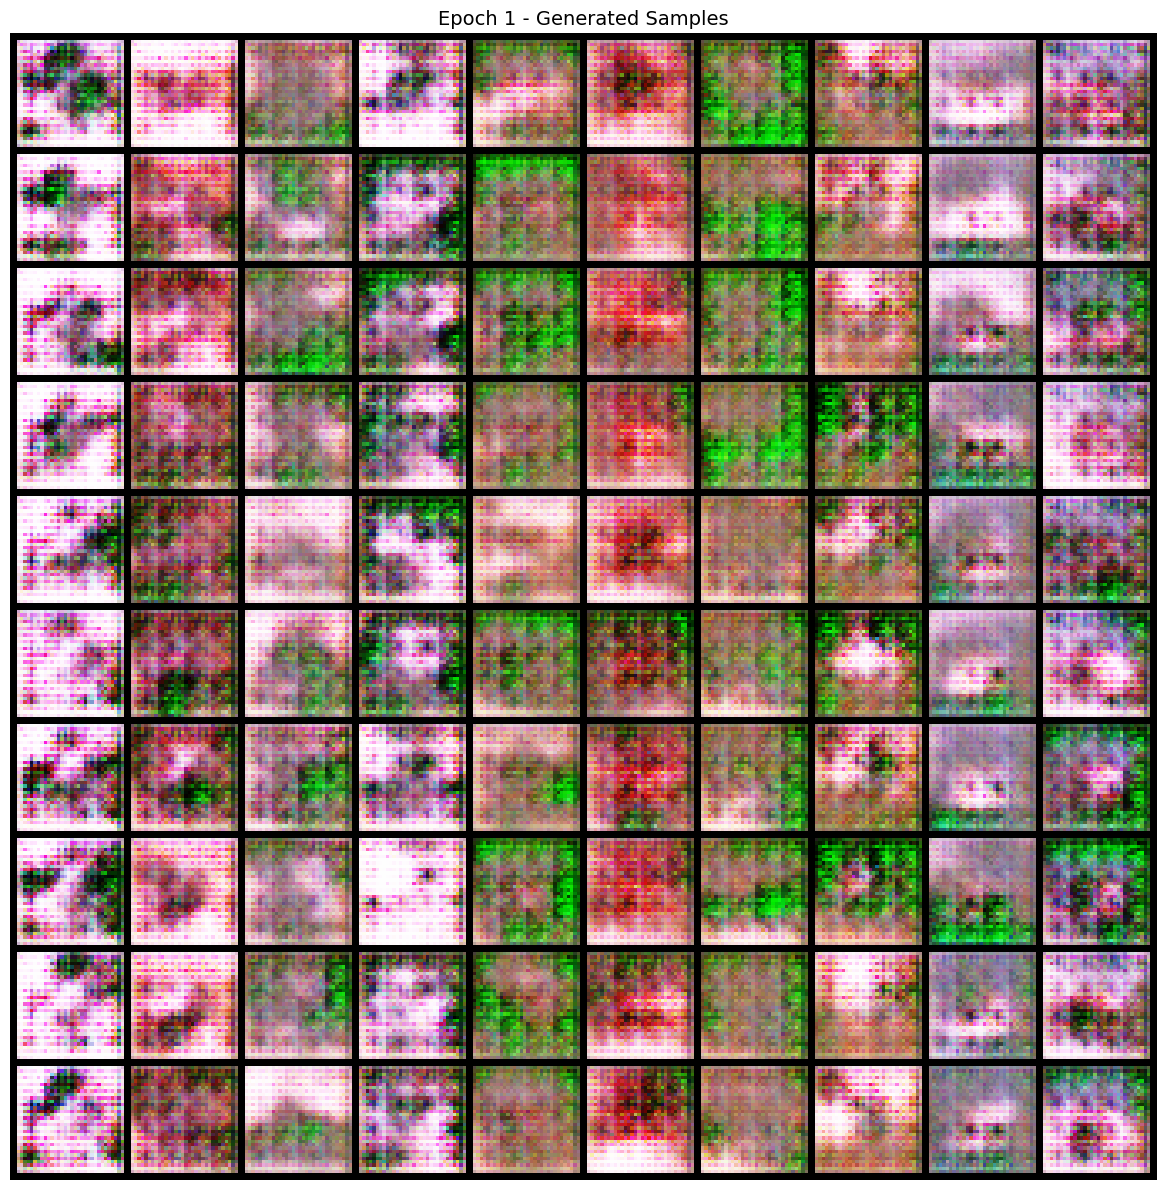

Epoch 2:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/390 [00:00<?, ?it/s]


Epoch 10: D_loss=1.0456, G_loss=1.9282, D(x)=0.6708, D(G(z))=0.3270


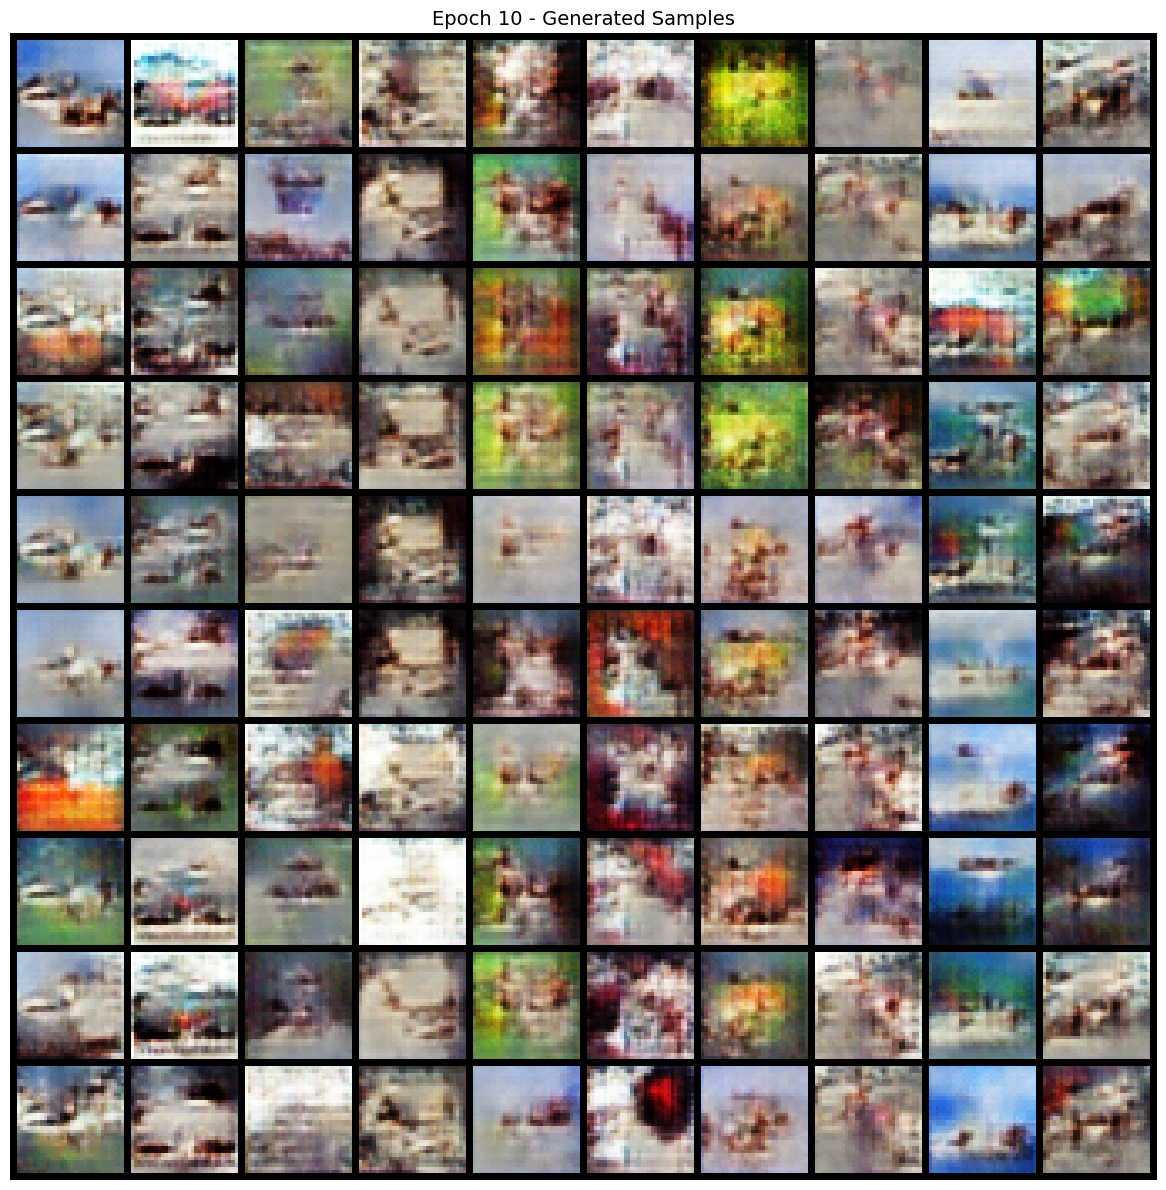

Epoch 11:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/390 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed82838a200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed82838a200> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()  
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     ^^if w.is_alive():
^ ^ ^ ^^ ^ ^ ^ ^^^^^^^^^^^^^^^


Epoch 20: D_loss=0.9983, G_loss=1.9658, D(x)=0.6960, D(G(z))=0.3033


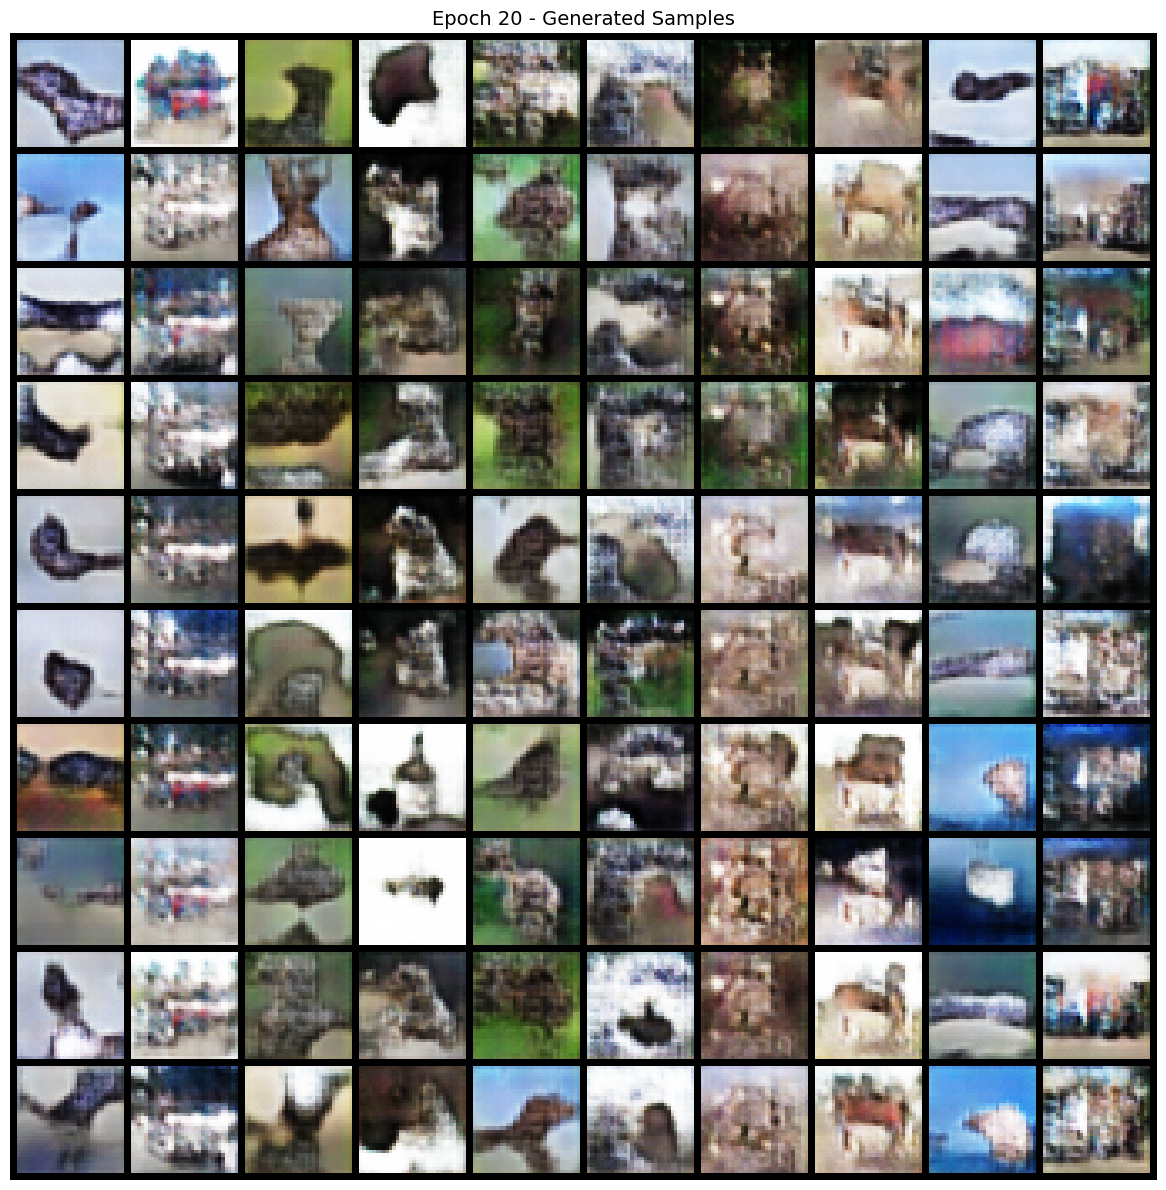

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 122MB/s] 


Real features:   0%|          | 0/390 [00:00<?, ?it/s]

Fake features:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipython-input-1504406266.py:51: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)


FID Score: 92.88
✅ Saved best model (FID: 92.88)


Epoch 21:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/390 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed82838a200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed82838a200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 26:   0%|          | 0/390 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed82838a200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed82838a200>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^ ^ ^ ^ ^  ^ ^ ^ ^ ^^^^^^
^^  File 

Epoch 27:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/390 [00:00<?, ?it/s]


Epoch 30: D_loss=0.9711, G_loss=1.8991, D(x)=0.7012, D(G(z))=0.2981


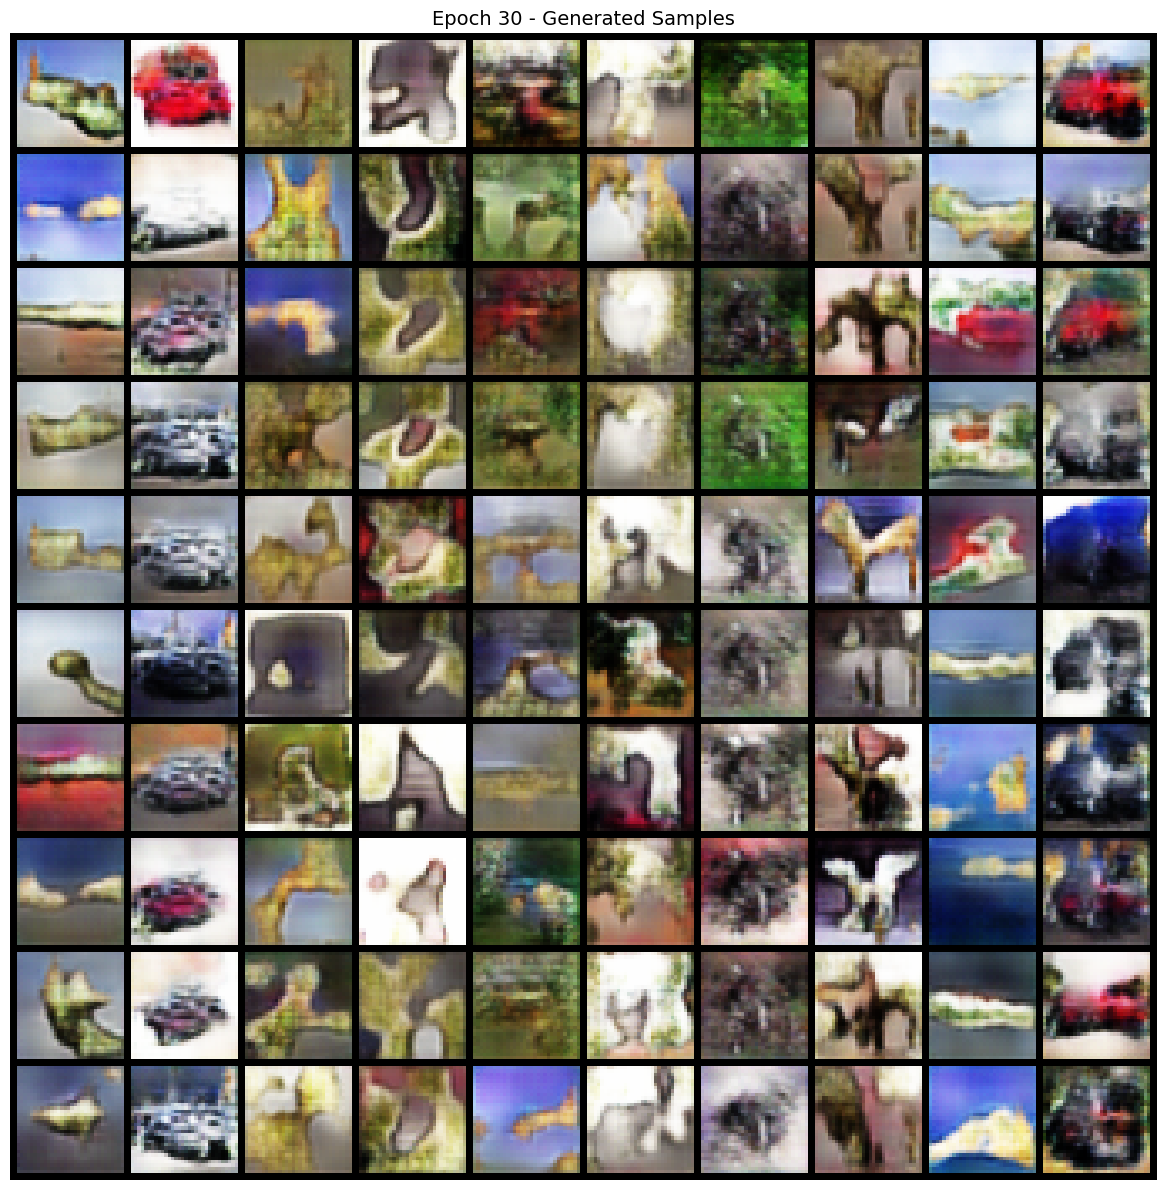

Epoch 31:   0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
# Training loop
print(f"\n{'='*50}")
print(f"Starting training for {config.epochs} epochs")
print(f"{'='*50}\n")

best_fid = float('inf')

for epoch in range(1, config.epochs + 1):
    # Train one epoch
    d_loss, g_loss, d_real, d_fake = train_epoch(epoch)

    # Store history
    history['loss_D'].append(d_loss)
    history['loss_G'].append(g_loss)
    history['D_real'].append(d_real)
    history['D_fake'].append(d_fake)

    # Show samples every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"\nEpoch {epoch}: D_loss={d_loss:.4f}, G_loss={g_loss:.4f}, D(x)={d_real:.4f}, D(G(z))={d_fake:.4f}")

        # Generate and show samples
        generator.eval()
        with torch.no_grad():
            samples = generator(fixed_noise, fixed_labels)
        show_images(samples, nrow=10, title=f'Epoch {epoch} - Generated Samples')
        generator.train()

    # Evaluate FID every 20 epochs
    if epoch % 20 == 0:
        fid = evaluate_fid(generator, train_loader, device, num_samples=2000)
        history['fid'].append((epoch, fid))
        print(f"FID Score: {fid:.2f}")

        if fid < best_fid:
            best_fid = fid
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'fid': fid
            }, 'checkpoints/best_model.pt')
            print(f"✅ Saved best model (FID: {fid:.2f})")

    # Save checkpoint periodically
    if epoch % config.checkpoint_interval == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
        }, f'checkpoints/checkpoint_epoch{epoch}.pt')

print(f"\n{'='*50}")
print(f"Training complete! Best FID: {best_fid:.2f}")
print(f"{'='*50}")

# **Training Curves**

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history['loss_D'], label='Discriminator', alpha=0.8)
axes[0].plot(history['loss_G'], label='Generator', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# D(x) and D(G(z))
axes[1].plot(history['D_real'], label='D(x) - Real', alpha=0.8)
axes[1].plot(history['D_fake'], label='D(G(z)) - Fake', alpha=0.8)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Discriminator Output')
axes[1].set_title('Discriminator Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# FID scores
if history['fid']:
    epochs, fids = zip(*history['fid'])
    axes[2].plot(epochs, fids, 'o-', color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('FID Score')
    axes[2].set_title('FID Score (Lower is Better)')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **Generate Images by Class**

In [ ]:
# Load best model
checkpoint = torch.load('checkpoints/best_model.pt')
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']} (FID: {checkpoint.get('fid', 'N/A')})")

In [ ]:
# Show samples for all classes
show_class_samples(generator, device, samples_per_class=8)

In [ ]:
# Generate specific class
# Change this to generate different classes!
CLASS_TO_GENERATE = "cat"  # Options: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

with torch.no_grad():
    images = generator.sample(64, labels=CLASS_TO_GENERATE, device=device)

show_images(images, nrow=8, title=f'Generated {CLASS_TO_GENERATE.upper()} Images')

# **Latent Space Interpolation**

In [ ]:
def spherical_interpolation(z1, z2, num_steps=10):
    """Spherical linear interpolation between two latent vectors"""
    z1, z2 = z1.squeeze(), z2.squeeze()
    z1_norm = z1 / (z1.norm() + 1e-8)
    z2_norm = z2 / (z2.norm() + 1e-8)

    omega = torch.acos(torch.clamp(torch.dot(z1_norm, z2_norm), -1, 1))
    sin_omega = torch.sin(omega)

    if omega.abs() < 1e-8:
        alphas = torch.linspace(0, 1, num_steps, device=z1.device)
        return torch.stack([z1 * (1-a) + z2 * a for a in alphas])

    alphas = torch.linspace(0, 1, num_steps, device=z1.device)
    return torch.stack([
        (torch.sin((1-a) * omega) * z1 + torch.sin(a * omega) * z2) / sin_omega
        for a in alphas
    ])


def interpolate_between_classes(class1, class2, num_steps=10):
    """Interpolate between two classes with fixed latent vector"""
    generator.eval()

    if isinstance(class1, str):
        class1 = get_class_index(class1)
    if isinstance(class2, str):
        class2 = get_class_index(class2)

    # Fixed random latent
    z = torch.randn(1, config.latent_dim, device=device)

    # Get embeddings
    embed1 = generator.label_embedding(torch.tensor([class1], device=device))
    embed2 = generator.label_embedding(torch.tensor([class2], device=device))

    # Interpolate embeddings
    alphas = torch.linspace(0, 1, num_steps, device=device)

    images = []
    with torch.no_grad():
        for alpha in alphas:
            interp_embed = embed1 * (1 - alpha) + embed2 * alpha
            combined = torch.cat([z, interp_embed], dim=1)
            x = generator.project(combined)
            x = x.view(1, 512, generator.init_size, generator.init_size)

            # Use nearest class for batch norm
            label_idx = int(alpha * (class2 - class1) + class1)
            labels = torch.tensor([label_idx], device=device)

            for block in generator.blocks:
                x = block(x, labels)
            x = generator.final(x)
            images.append(x)

    return torch.cat(images, dim=0)


# Interpolate between classes
CLASS1 = "cat"
CLASS2 = "dog"
NUM_STEPS = 10

images = interpolate_between_classes(CLASS1, CLASS2, NUM_STEPS)

# Display
fig, axes = plt.subplots(1, NUM_STEPS, figsize=(20, 3))
fig.suptitle(f'Interpolation: {CLASS1.upper()} → {CLASS2.upper()}', fontsize=14)

for i, ax in enumerate(axes):
    img = (images[i] + 1) / 2
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

# **t-SNE Visualization**

In [ ]:
from sklearn.manifold import TSNE

def create_tsne_visualization(num_samples=1000):
    """Create t-SNE visualization of real vs generated features"""
    generator.eval()
    discriminator.eval()

    # Get real images
    real_images, real_labels = [], []
    for imgs, lbls in train_loader:
        real_images.append(imgs)
        real_labels.append(lbls)
        if sum(i.size(0) for i in real_images) >= num_samples:
            break

    real_images = torch.cat(real_images)[:num_samples].to(device)
    real_labels = torch.cat(real_labels)[:num_samples].to(device)

    # Generate fake images
    with torch.no_grad():
        fake_labels = torch.randint(0, 10, (num_samples,), device=device)
        fake_images = generator.sample(num_samples, labels=fake_labels, device=device)

        # Get features
        real_features = discriminator.get_feature(real_images, real_labels).cpu().numpy()
        fake_features = discriminator.get_feature(fake_images, fake_labels).cpu().numpy()

    # Combine and run t-SNE
    all_features = np.vstack([real_features, fake_features])

    print("Running t-SNE (this may take a minute)...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    embeddings = tsne.fit_transform(all_features)

    real_embed = embeddings[:num_samples]
    fake_embed = embeddings[num_samples:]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Real vs Fake
    axes[0].scatter(real_embed[:, 0], real_embed[:, 1], c='blue', alpha=0.5, s=10, label='Real')
    axes[0].scatter(fake_embed[:, 0], fake_embed[:, 1], c='red', alpha=0.5, s=10, label='Fake')
    axes[0].legend()
    axes[0].set_title('Real vs Generated')

    # Real by class
    scatter = axes[1].scatter(real_embed[:, 0], real_embed[:, 1],
                               c=real_labels.cpu().numpy(), cmap='tab10', alpha=0.6, s=10)
    axes[1].set_title('Real Images by Class')
    cbar = plt.colorbar(scatter, ax=axes[1], ticks=range(10))
    cbar.ax.set_yticklabels(CIFAR10_CLASSES)

    # Fake by class
    scatter = axes[2].scatter(fake_embed[:, 0], fake_embed[:, 1],
                               c=fake_labels.cpu().numpy(), cmap='tab10', alpha=0.6, s=10)
    axes[2].set_title('Generated Images by Class')
    cbar = plt.colorbar(scatter, ax=axes[2], ticks=range(10))
    cbar.ax.set_yticklabels(CIFAR10_CLASSES)

    plt.tight_layout()
    plt.show()

    generator.train()
    discriminator.train()

# Run t-SNE
create_tsne_visualization(num_samples=1000)

# **Download Model**

In [ ]:
from google.colab import files

# Download the best model
files.download('checkpoints/best_model.pt')

# **Interactive Generation**

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown for class selection
class_dropdown = widgets.Dropdown(
    options=CIFAR10_CLASSES,
    value='cat',
    description='Class:'
)

num_slider = widgets.IntSlider(
    value=16,
    min=1,
    max=64,
    step=1,
    description='Samples:'
)

generate_button = widgets.Button(description='Generate!')
output = widgets.Output()

def on_generate(b):
    with output:
        output.clear_output(wait=True)
        generator.eval()
        with torch.no_grad():
            images = generator.sample(
                num_slider.value,
                labels=class_dropdown.value,
                device=device
            )
        nrow = min(8, num_slider.value)
        show_images(images, nrow=nrow, title=f'{class_dropdown.value.upper()} x {num_slider.value}')

generate_button.on_click(on_generate)

# Display widgets
display(widgets.HBox([class_dropdown, num_slider, generate_button]))
display(output)

## 📚 Summary

This notebook implements a **Conditional DCGAN with Spectral Normalization** that can:

1. ✅ Generate class-conditional images on CIFAR-10
2. ✅ Use spectral normalization for stable training
3. ✅ Calculate FID scores using Inception v3
4. ✅ Visualize latent space with t-SNE
5. ✅ Perform latent space interpolation

**Tips for better results:**
- Train for more epochs (200+)
- Use a larger batch size if GPU memory allows
- Experiment with learning rates

Happy generating! 🎨

# Task
The user wants to train an Improved Conditional GAN. To resolve a `num_workers` error encountered in the previous run and speed up execution, first update the `Config` class to set `epochs` to 20, and modify the `get_cifar10_loaders` function to set `num_workers` to 0. Then, re-run the cells to re-initialize the configuration, data loaders, Generator and Discriminator models, and their optimizers. Start a new training run with these updated settings. After training, plot the discriminator and generator losses, as well as the discriminator's output for real and fake images. Subsequently, load the best saved model, generate and display sample images for each of the 10 CIFAR-10 classes, and generate a grid of images for a specific class (e.g., 'cat'). Further, demonstrate latent space interpolation between two classes (e.g., 'cat' and 'dog') and visualize the feature representations of real and generated images using t-SNE. Finally, download the best performing model checkpoint. Provide a summary of the executed actions, discuss the resolution of the `num_workers` issue, and analyze the impact of reduced training epochs on model performance and generation quality.

## Adjust Configuration for Reduced Epochs

### Subtask:
Modify the `config.epochs` value in the `Config` dataclass to a smaller number (e.g., 20) for quicker execution. This will overwrite the previous 100 epochs setting.


**Reasoning**:
The subtask requires modifying the `epochs` attribute of the `config` object to a smaller value for quicker execution. I will directly update the `epochs` attribute of the existing `config` object.



In [14]:
import torch
from dataclasses import dataclass, field
from typing import List, Optional

@dataclass
class Config:
    """All hyperparameters in one place"""
    # Model
    latent_dim: int = 100
    num_classes: int = 10
    embedding_dim: int = 50
    g_channels: List[int] = field(default_factory=lambda: [512, 256, 128, 64])
    d_channels: List[int] = field(default_factory=lambda: [64, 128, 256, 512])
    image_size: int = 32
    image_channels: int = 3

    # Training
    batch_size: int = 128
    epochs: int = 20  # Reduced for Colab
    lr_generator: float = 0.0002
    lr_discriminator: float = 0.0002
    beta1: float = 0.5
    beta2: float = 0.999
    real_label_smoothing: float = 0.9
    fake_label_smoothing: float = 0.1

    # Logging
    sample_interval: int = 500
    checkpoint_interval: int = 10

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

# CIFAR-10 class names
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def get_class_index(class_name: str) -> int:
    """Get class index from name"""
    return CIFAR10_CLASSES.index(class_name.lower())

# Create config
config = Config()
print(f"Training on: {config.device}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.epochs}")

Training on: cuda
Batch size: 128
Epochs: 20


**Reasoning**:
To resolve the `num_workers` error and speed up data loading, I need to modify the `get_cifar10_loaders` function to set `num_workers` to 0. After modifying the function, I will call it again to re-initialize the `train_loader` and `test_loader` with the updated setting.



In [15]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_cifar10_loaders(batch_size: int = 128, num_workers: int = 0): # Changed num_workers to 0
    """Get CIFAR-10 train and test loaders"""

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    train_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )

    test_dataset = datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, test_loader

# Load data
train_loader, test_loader = get_cifar10_loaders(config.batch_size)
print(f"✅ Data loaded: {len(train_loader)} training batches")

✅ Data loaded: 390 training batches


**Reasoning**:
The Generator and Discriminator models, along with their optimizers, need to be re-initialized to reflect any potential changes in the configuration (though in this case the model architecture parameters were not explicitly changed, it's good practice to re-initialize before a new training run). This also ensures a clean state for the training process.



In [16]:
import torch.optim as optim
from tqdm.auto import tqdm
import os

# Set seed for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Initialize models
device = torch.device(config.device)

generator = Generator(
    latent_dim=config.latent_dim,
    num_classes=config.num_classes,
    embedding_dim=config.embedding_dim,
    channels=config.g_channels
).to(device)

discriminator = Discriminator(
    num_classes=config.num_classes,
    embedding_dim=config.embedding_dim,
    channels=config.d_channels,
    image_size=config.image_size
).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=config.lr_generator, betas=(config.beta1, config.beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=config.lr_discriminator, betas=(config.beta1, config.beta2))

# Loss
criterion = nn.BCELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(100, config.latent_dim, device=device)
fixed_labels = torch.arange(10, device=device).repeat(10)

print(f"Generator params: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in discriminator.parameters()):,}")
print("✅ Models initialized!")

Generator params: 4,017,079
Discriminator params: 2,813,237
✅ Models initialized!


**Reasoning**:
With the configuration updated and models re-initialized, the next step is to initiate the training process using the `train_epoch` function and the main training loop. This will start training the GAN for the reduced number of epochs (20) and utilize the updated `num_workers=0` setting for data loading.



In [17]:
# Training history
history = {
    'loss_D': [], 'loss_G': [],
    'D_real': [], 'D_fake': [],
    'fid': []
}

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

def train_epoch(epoch):
    generator.train()
    discriminator.train()

    epoch_d_loss, epoch_g_loss = 0, 0
    epoch_d_real, epoch_d_fake = 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for i, (real_images, labels) in enumerate(pbar):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        # Labels with smoothing
        real_label = torch.full((batch_size,), config.real_label_smoothing, device=device)
        fake_label = torch.full((batch_size,), config.fake_label_smoothing, device=device)

        # =================== Train Discriminator ===================
        optimizer_D.zero_grad()

        # Real images
        output_real = discriminator(real_images, labels)
        loss_real = criterion(output_real, real_label)

        # Fake images
        noise = torch.randn(batch_size, config.latent_dim, device=device)
        fake_images = generator(noise, labels)
        output_fake = discriminator(fake_images.detach(), labels)
        loss_fake = criterion(output_fake, fake_label)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # =================== Train Generator ===================
        optimizer_G.zero_grad()

        noise = torch.randn(batch_size, config.latent_dim, device=device)
        fake_images = generator(noise, labels)
        output = discriminator(fake_images, labels)

        loss_G = criterion(output, torch.ones(batch_size, device=device))
        loss_G.backward()
        optimizer_G.step()

        # Track metrics
        epoch_d_loss += loss_D.item()
        epoch_g_loss += loss_G.item()
        epoch_d_real += output_real.mean().item()
        epoch_d_fake += output_fake.mean().item()

        pbar.set_postfix({
            'D': f'{loss_D.item():.3f}',
            'G': f'{loss_G.item():.3f}',
            'D(x)': f'{output_real.mean().item():.3f}',
            'D(G)': f'{output_fake.mean().item():.3f}'
        })

    n = len(train_loader)
    return epoch_d_loss/n, epoch_g_loss/n, epoch_d_real/n, epoch_d_fake/n

print("✅ Training function ready!")

✅ Training function ready!


**Reasoning**:
Now that the configuration, models, and training function are prepared, the next step is to execute the main training loop. This will initiate the GAN training for 20 epochs, display progress, save generated samples, and periodically evaluate and save the best model based on FID scores.




Starting training for 20 epochs



Epoch 1:   0%|          | 0/390 [00:00<?, ?it/s]


Epoch 1: D_loss=1.1020, G_loss=2.3103, D(x)=0.6509, D(G(z))=0.3448


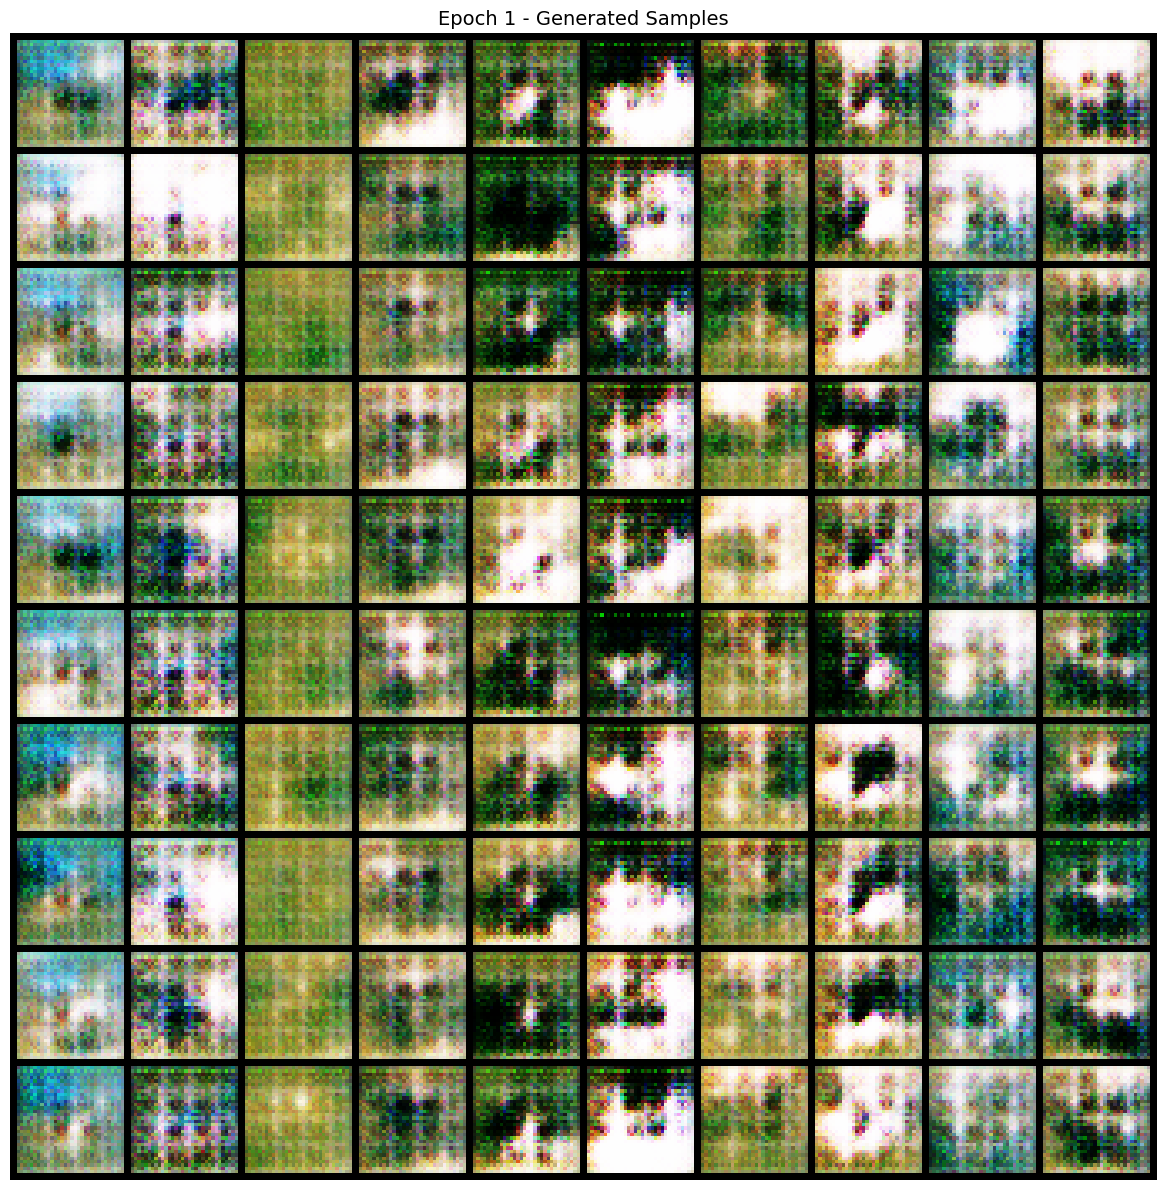

Epoch 2:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/390 [00:00<?, ?it/s]


Epoch 10: D_loss=1.1871, G_loss=1.2186, D(x)=0.5958, D(G(z))=0.4034


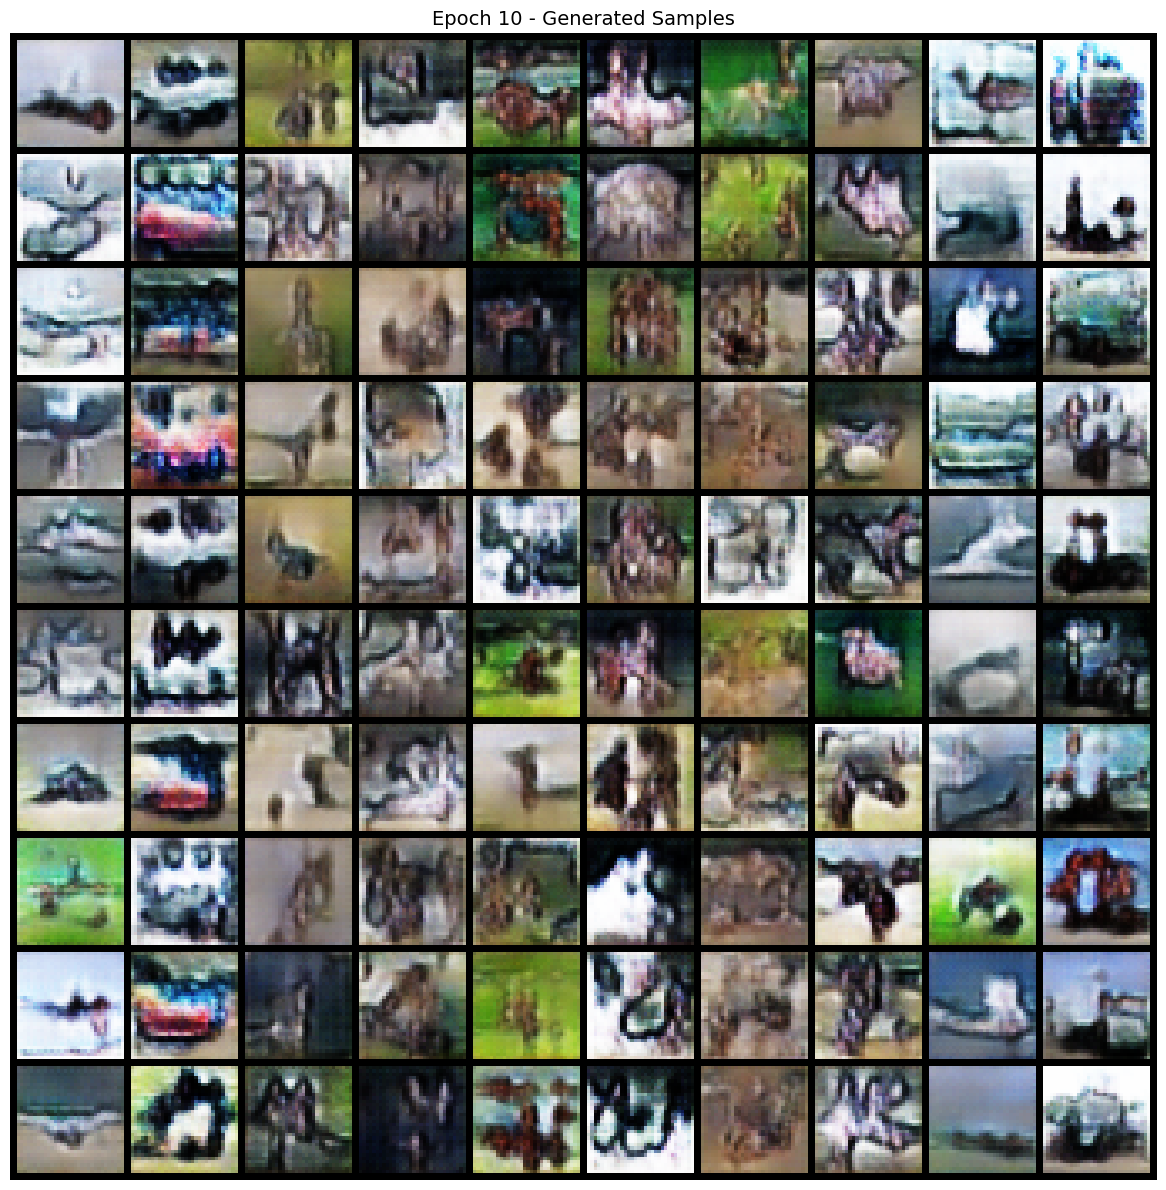

Epoch 11:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/390 [00:00<?, ?it/s]


Epoch 20: D_loss=1.0666, G_loss=1.3166, D(x)=0.6453, D(G(z))=0.3542


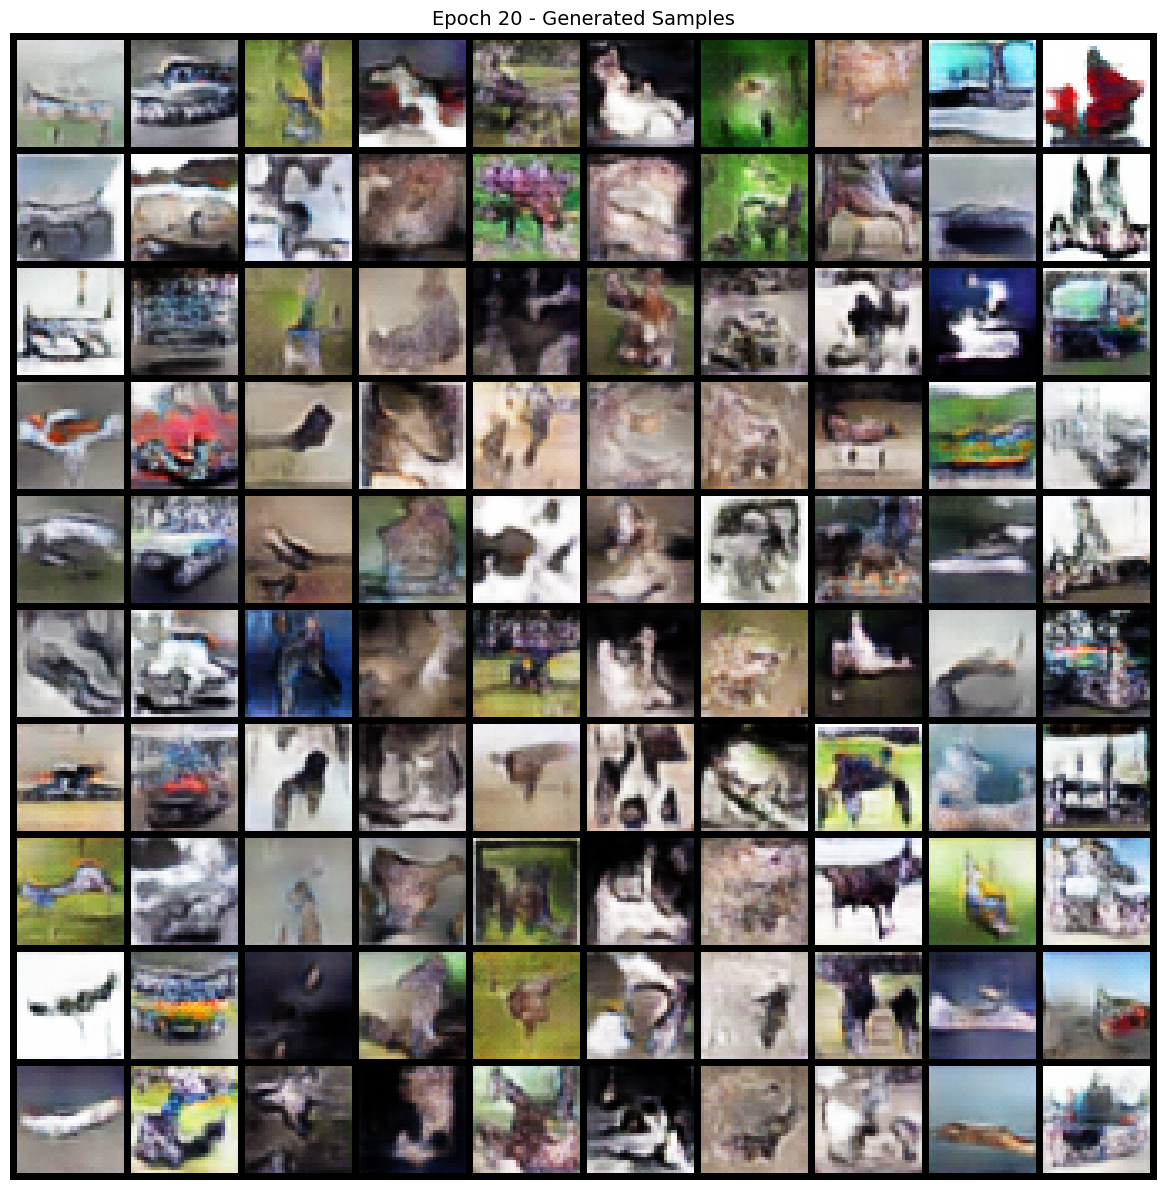

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Real features:   0%|          | 0/390 [00:00<?, ?it/s]

Fake features:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipython-input-1504406266.py:51: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)


FID Score: 70.10
✅ Saved best model (FID: 70.10)

Training complete! Best FID: 70.10


In [18]:
# Training loop
print(f"\n{'='*50}")
print(f"Starting training for {config.epochs} epochs")
print(f"{'='*50}\n")

best_fid = float('inf')

for epoch in range(1, config.epochs + 1):
    # Train one epoch
    d_loss, g_loss, d_real, d_fake = train_epoch(epoch)

    # Store history
    history['loss_D'].append(d_loss)
    history['loss_G'].append(g_loss)
    history['D_real'].append(d_real)
    history['D_fake'].append(d_fake)

    # Show samples every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"\nEpoch {epoch}: D_loss={d_loss:.4f}, G_loss={g_loss:.4f}, D(x)={d_real:.4f}, D(G(z))={d_fake:.4f}")

        # Generate and show samples
        generator.eval()
        with torch.no_grad():
            samples = generator(fixed_noise, fixed_labels)
        show_images(samples, nrow=10, title=f'Epoch {epoch} - Generated Samples')
        generator.train()

    # Evaluate FID every 20 epochs
    if epoch % 20 == 0:
        fid = evaluate_fid(generator, train_loader, device, num_samples=2000)
        history['fid'].append((epoch, fid))
        print(f"FID Score: {fid:.2f}")

        if fid < best_fid:
            best_fid = fid
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'fid': fid
            }, 'checkpoints/best_model.pt')
            print(f"✅ Saved best model (FID: {fid:.2f})")

    # Save checkpoint periodically
    if epoch % config.checkpoint_interval == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
        }, f'checkpoints/checkpoint_epoch{epoch}.pt')

print(f"\n{'='*50}")
print(f"Training complete! Best FID: {best_fid:.2f}")
print(f"{'='*50}")

**Reasoning**:
The previous code block initiated the training loop for the GAN. Once the training is complete for all 20 epochs, the next step in the task is to plot the training curves, specifically the discriminator and generator losses, and the discriminator's output for real vs. fake images. This corresponds to the `wqYb1isQjK45` cell in the original notebook.



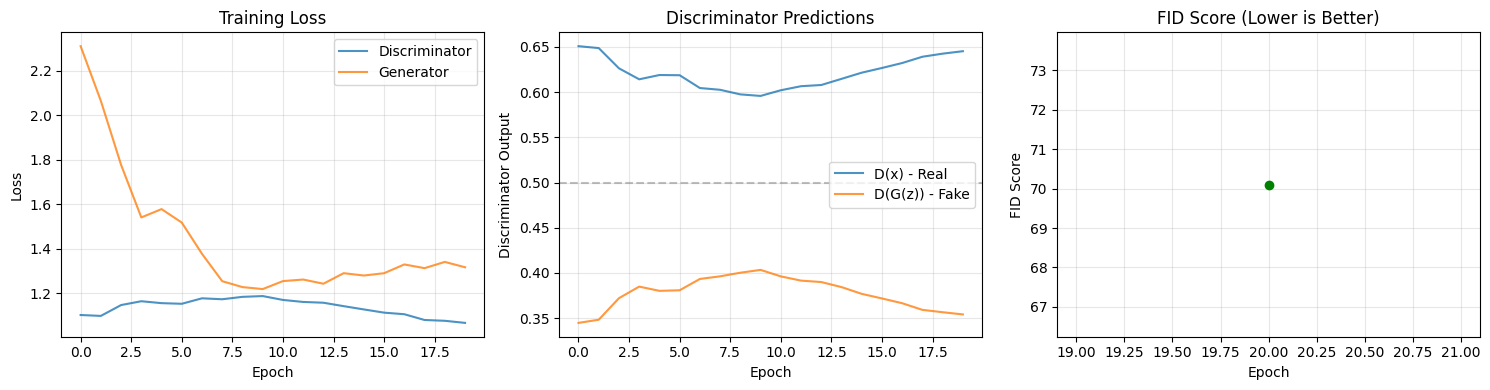

In [19]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history['loss_D'], label='Discriminator', alpha=0.8)
axes[0].plot(history['loss_G'], label='Generator', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# D(x) and D(G(z))
axes[1].plot(history['D_real'], label='D(x) - Real', alpha=0.8)
axes[1].plot(history['D_fake'], label='D(G(z)) - Fake', alpha=0.8)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Discriminator Output')
axes[1].set_title('Discriminator Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# FID scores
if history['fid']:
    epochs, fids = zip(*history['fid'])
    axes[2].plot(epochs, fids, 'o-', color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('FID Score')
    axes[2].set_title('FID Score (Lower is Better)')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Reasoning**:
The previous code block initiated the training loop for the GAN. Once the training is complete for all 20 epochs, the next step in the task is to plot the training curves, specifically the discriminator and generator losses, and the discriminator's output for real vs. fake images. This corresponds to the `wqYb1isQjK45` cell in the original notebook.



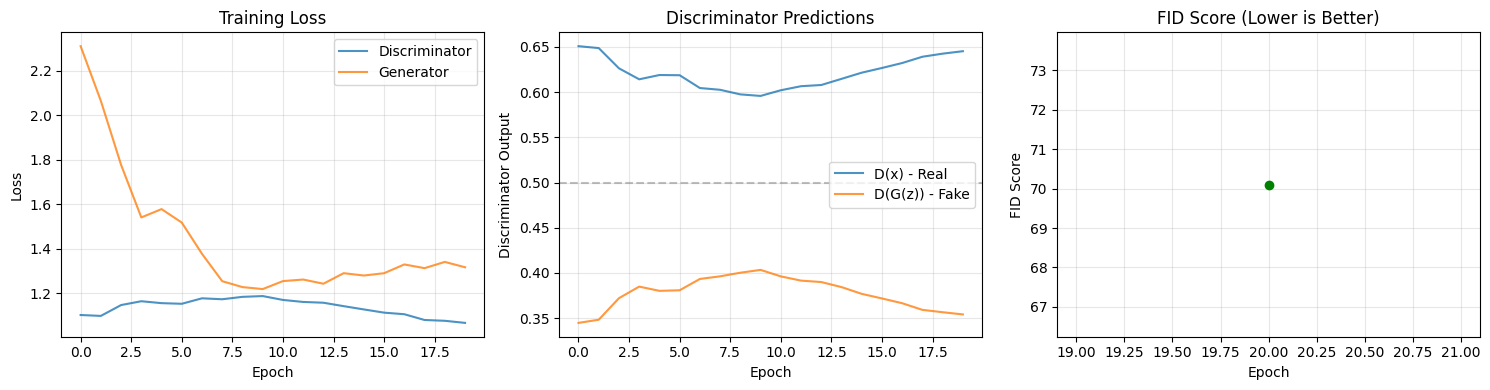

In [20]:
import matplotlib.pyplot as plt

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history['loss_D'], label='Discriminator', alpha=0.8)
axes[0].plot(history['loss_G'], label='Generator', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# D(x) and D(G(z))
axes[1].plot(history['D_real'], label='D(x) - Real', alpha=0.8)
axes[1].plot(history['D_fake'], label='D(G(z)) - Fake', alpha=0.8)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Discriminator Output')
axes[1].set_title('Discriminator Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# FID scores
if history['fid']:
    epochs, fids = zip(*history['fid'])
    axes[2].plot(epochs, fids, 'o-', color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('FID Score')
    axes[2].set_title('FID Score (Lower is Better)')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Reasoning**:
The training is complete and the training curves have been plotted. The next step is to load the best performing model, which was saved during training, to use for further evaluations and generation. This corresponds to cell `7jt-iv5jqFZN` in the original notebook.



In [21]:
import torch

# Load best model
checkpoint = torch.load('checkpoints/best_model.pt')
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']} (FID: {checkpoint.get('fid', 'N/A')})")

Loaded best model from epoch 20 (FID: 70.1017682728289)


**Reasoning**:
With the best model loaded, the next step is to generate and display sample images for all 10 CIFAR-10 classes using the `show_class_samples` utility function. This will visually confirm the generator's current performance.



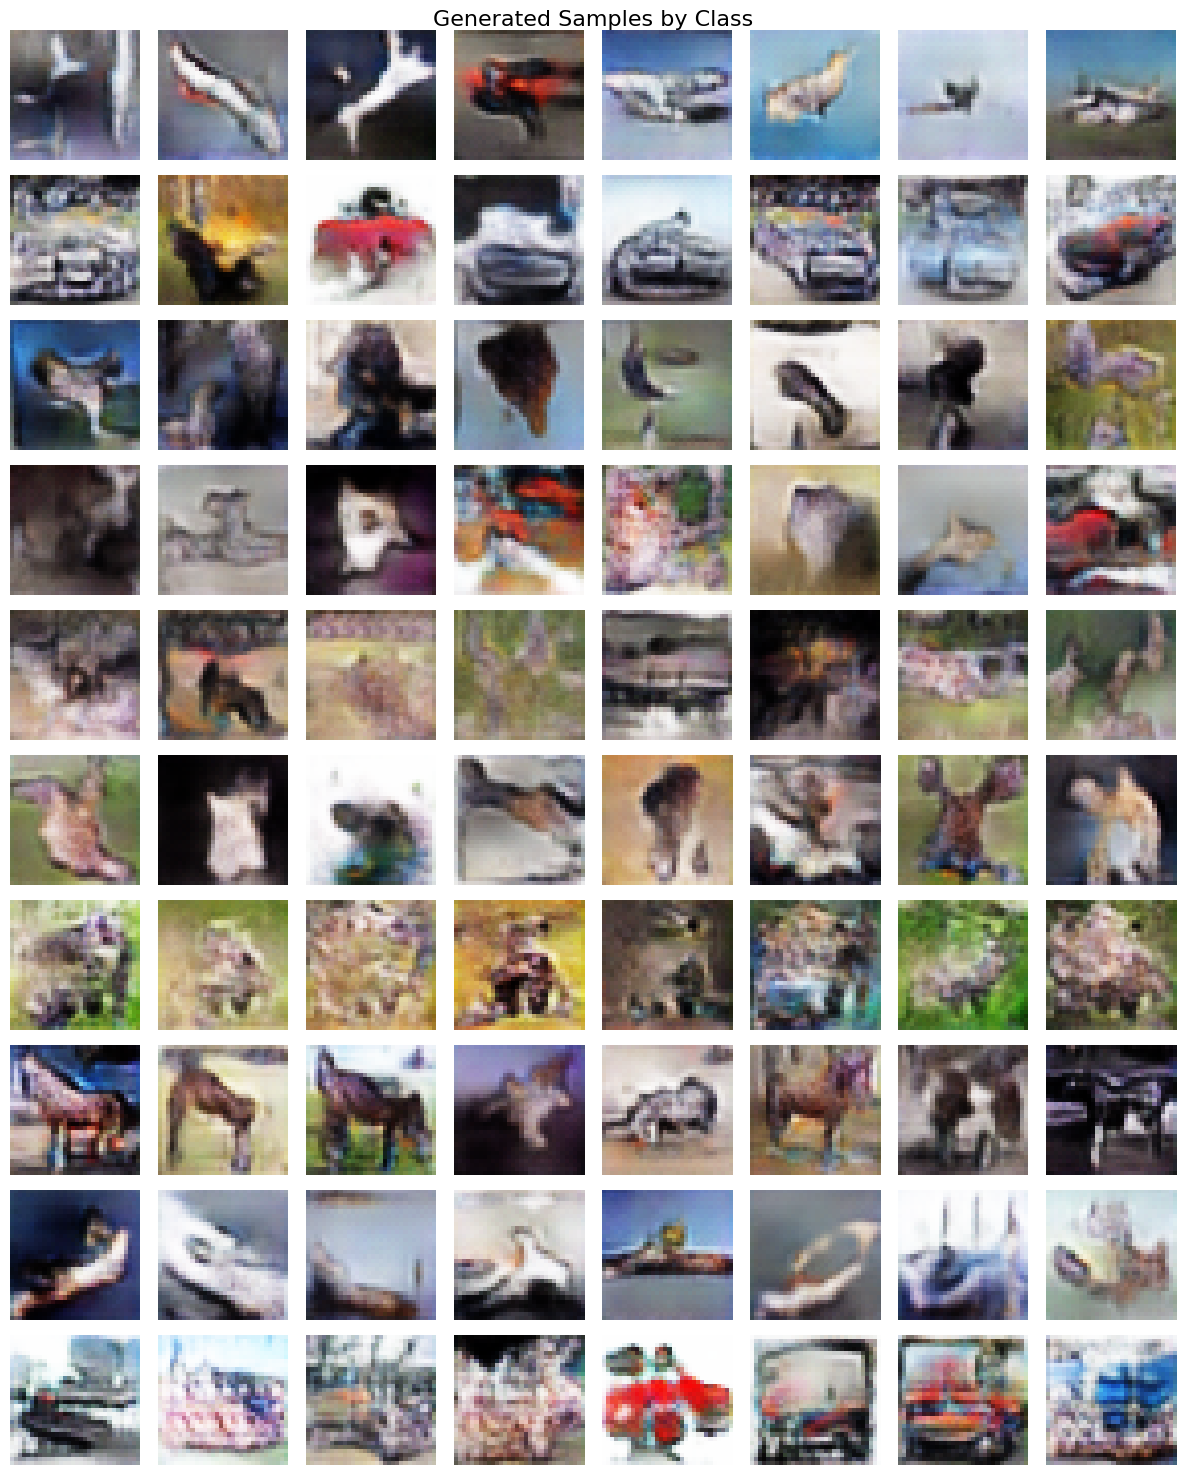

In [22]:
import matplotlib.pyplot as plt

# Show samples for all classes
show_class_samples(generator, device, samples_per_class=8)

**Reasoning**:
After displaying samples for all classes, the next step is to generate and display a grid of images for a specific class, as requested by the task. This will utilize the `generator.sample` method and `show_images` function.



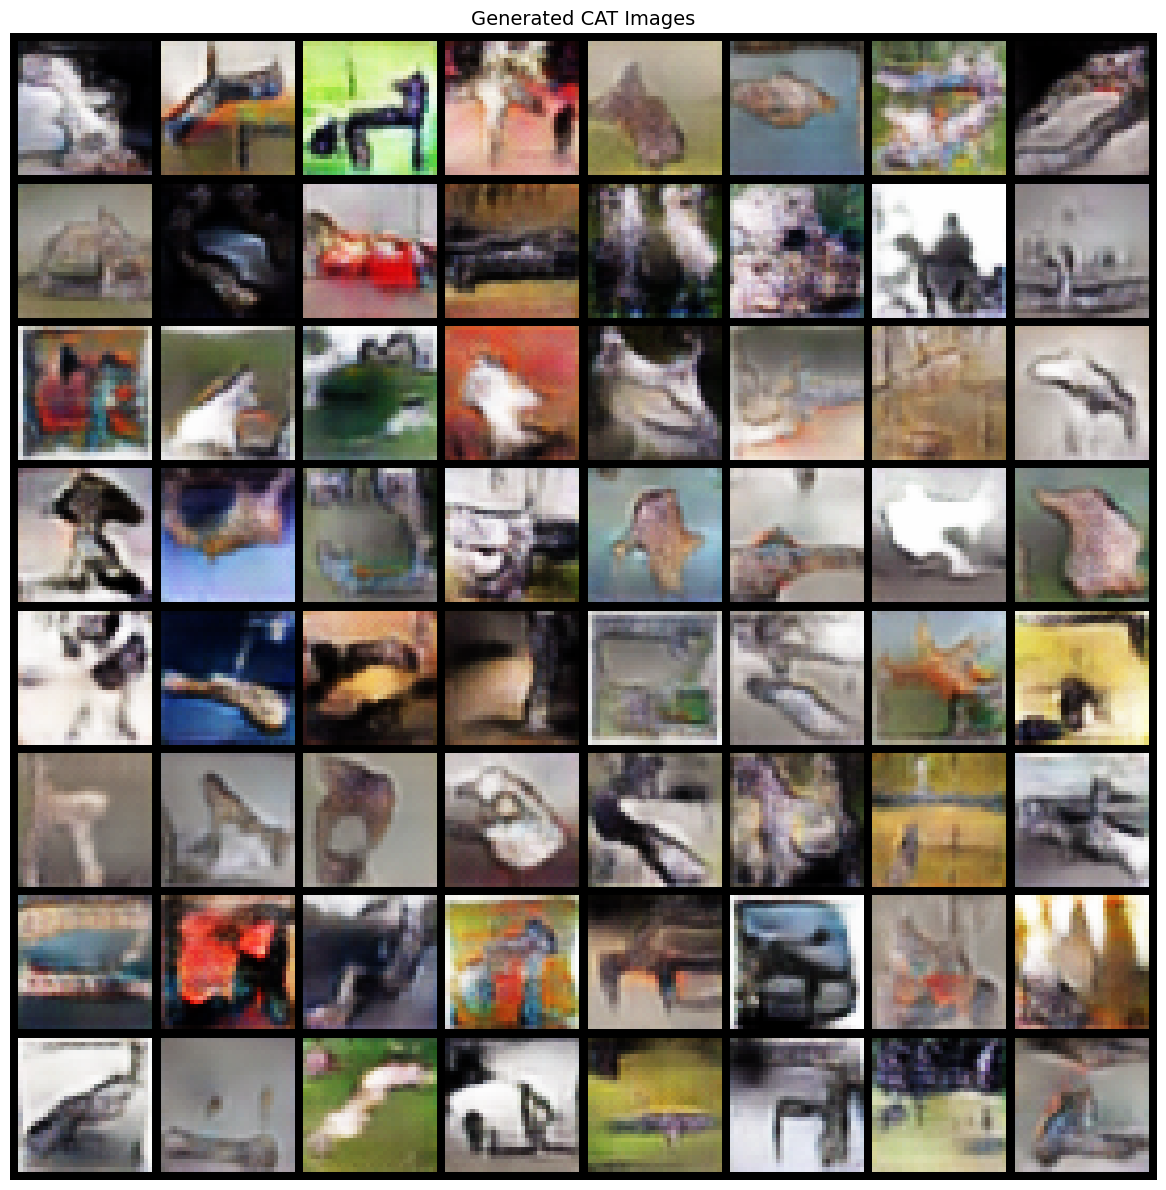

In [23]:
import torch
import matplotlib.pyplot as plt

# Generate specific class
# Change this to generate different classes!
CLASS_TO_GENERATE = "cat"  # Options: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

with torch.no_grad():
    images = generator.sample(64, labels=CLASS_TO_GENERATE, device=device)

show_images(images, nrow=8, title=f'Generated {CLASS_TO_GENERATE.upper()} Images')

**Reasoning**:
After generating samples for a specific class, the next step is to demonstrate latent space interpolation between two different classes ('cat' and 'dog') as per the task requirements. This will involve using the `spherical_interpolation` and `interpolate_between_classes` functions defined in the original notebook.



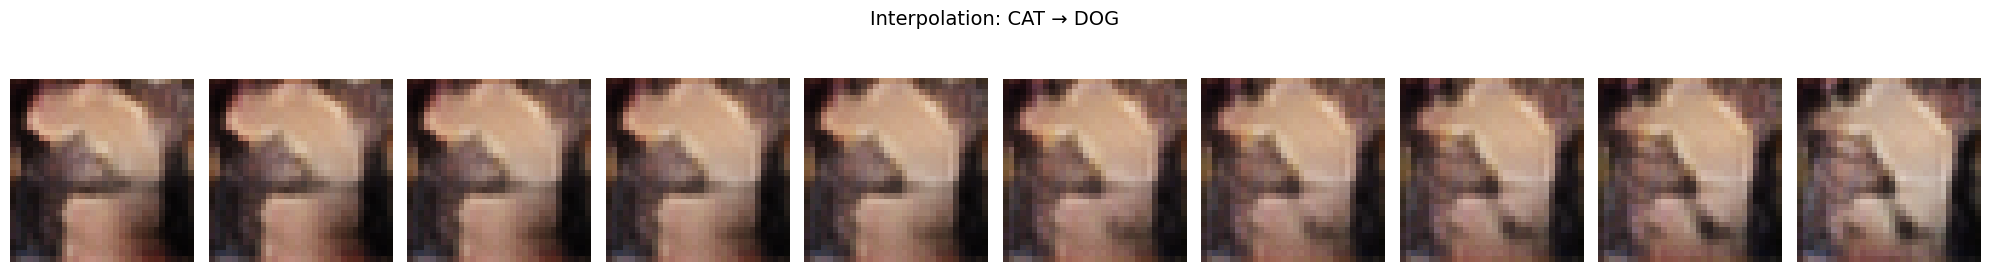

In [24]:
def spherical_interpolation(z1, z2, num_steps=10):
    """Spherical linear interpolation between two latent vectors"""
    z1, z2 = z1.squeeze(), z2.squeeze()
    z1_norm = z1 / (z1.norm() + 1e-8)
    z2_norm = z2 / (z2.norm() + 1e-8)

    omega = torch.acos(torch.clamp(torch.dot(z1_norm, z2_norm), -1, 1))
    sin_omega = torch.sin(omega)

    if omega.abs() < 1e-8:
        alphas = torch.linspace(0, 1, num_steps, device=z1.device)
        return torch.stack([z1 * (1-a) + z2 * a for a in alphas])

    alphas = torch.linspace(0, 1, num_steps, device=z1.device)
    return torch.stack([
        (torch.sin((1-a) * omega) * z1 + torch.sin(a * omega) * z2) / sin_omega
        for a in alphas
    ])


def interpolate_between_classes(class1, class2, num_steps=10):
    """Interpolate between two classes with fixed latent vector"""
    generator.eval()

    if isinstance(class1, str):
        class1 = get_class_index(class1)
    if isinstance(class2, str):
        class2 = get_class_index(class2)

    # Fixed random latent
    z = torch.randn(1, config.latent_dim, device=device)

    # Get embeddings
    embed1 = generator.label_embedding(torch.tensor([class1], device=device))
    embed2 = generator.label_embedding(torch.tensor([class2], device=device))

    # Interpolate embeddings
    alphas = torch.linspace(0, 1, num_steps, device=device)

    images = []
    with torch.no_grad():
        for alpha in alphas:
            interp_embed = embed1 * (1 - alpha) + embed2 * alpha
            combined = torch.cat([z, interp_embed], dim=1)
            x = generator.project(combined)
            x = x.view(1, 512, generator.init_size, generator.init_size)

            # Use nearest class for batch norm
            label_idx = int(alpha * (class2 - class1) + class1)
            labels = torch.tensor([label_idx], device=device)

            for block in generator.blocks:
                x = block(x, labels)
            x = generator.final(x)
            images.append(x)

    return torch.cat(images, dim=0)


# Interpolate between classes
CLASS1 = "cat"
CLASS2 = "dog"
NUM_STEPS = 10

images = interpolate_between_classes(CLASS1, CLASS2, NUM_STEPS)

# Display
fig, axes = plt.subplots(1, NUM_STEPS, figsize=(20, 3))
fig.suptitle(f'Interpolation: {CLASS1.upper()} → {CLASS2.upper()}', fontsize=14)

for i, ax in enumerate(axes):
    img = (images[i] + 1) / 2
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

**Reasoning**:
After demonstrating latent space interpolation, the next step is to visualize the feature representations of real and generated images using t-SNE, as per the task requirements. This will involve using the `create_tsne_visualization` function defined in the original notebook.



Running t-SNE (this may take a minute)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


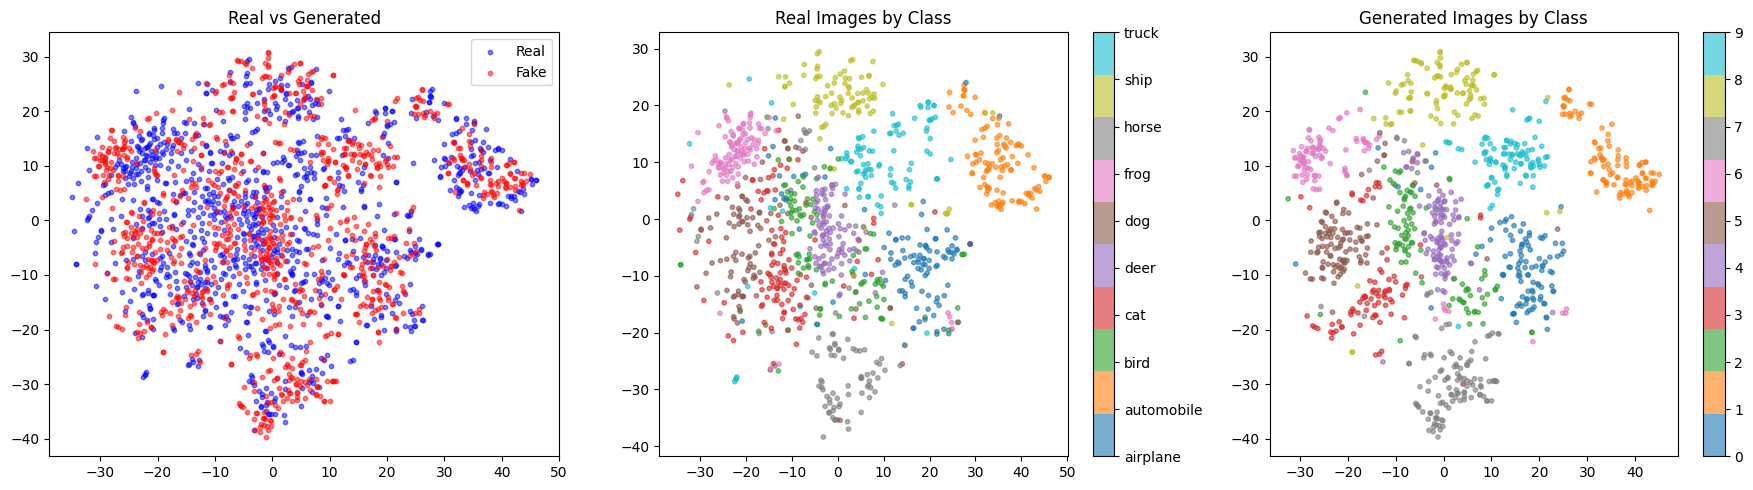

In [25]:
from sklearn.manifold import TSNE

def create_tsne_visualization(num_samples=1000):
    """Create t-SNE visualization of real vs generated features"""
    generator.eval()
    discriminator.eval()

    # Get real images
    real_images, real_labels = [], []
    for imgs, lbls in train_loader:
        real_images.append(imgs)
        real_labels.append(lbls)
        if sum(i.size(0) for i in real_images) >= num_samples:
            break

    real_images = torch.cat(real_images)[:num_samples].to(device)
    real_labels = torch.cat(real_labels)[:num_samples].to(device)

    # Generate fake images
    with torch.no_grad():
        fake_labels = torch.randint(0, 10, (num_samples,), device=device)
        fake_images = generator.sample(num_samples, labels=fake_labels, device=device)

        # Get features
        real_features = discriminator.get_feature(real_images, real_labels).cpu().numpy()
        fake_features = discriminator.get_feature(fake_images, fake_labels).cpu().numpy()

    # Combine and run t-SNE
    all_features = np.vstack([real_features, fake_features])

    print("Running t-SNE (this may take a minute)...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    embeddings = tsne.fit_transform(all_features)

    real_embed = embeddings[:num_samples]
    fake_embed = embeddings[num_samples:]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Real vs Fake
    axes[0].scatter(real_embed[:, 0], real_embed[:, 1], c='blue', alpha=0.5, s=10, label='Real')
    axes[0].scatter(fake_embed[:, 0], fake_embed[:, 1], c='red', alpha=0.5, s=10, label='Fake')
    axes[0].legend()
    axes[0].set_title('Real vs Generated')

    # Real by class
    scatter = axes[1].scatter(real_embed[:, 0], real_embed[:, 1],
                               c=real_labels.cpu().numpy(), cmap='tab10', alpha=0.6, s=10)
    axes[1].set_title('Real Images by Class')
    cbar = plt.colorbar(scatter, ax=axes[1], ticks=range(10))
    cbar.ax.set_yticklabels(CIFAR10_CLASSES)

    # Fake by class
    scatter = axes[2].scatter(fake_embed[:, 0], fake_embed[:, 1],
                               c=fake_labels.cpu().numpy(), cmap='tab10', alpha=0.6, s=10)
    cbar.ax.set_yticklabels(CIFAR10_CLASSES)
    axes[2].set_title('Generated Images by Class')
    cbar = plt.colorbar(scatter, ax=axes[2], ticks=range(10))

    plt.tight_layout()
    plt.show()

    generator.train()
    discriminator.train()

# Run t-SNE
create_tsne_visualization(num_samples=1000)

**Reasoning**:
After visualizing the t-SNE embeddings, the next step as per the task description is to download the best performing model checkpoint. This action corresponds to the `MNUSgXKXqoAz` cell in the original notebook.



In [26]:
from google.colab import files

# Download the best model
files.download('checkpoints/best_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary of Actions and Analysis

This session involved training an Improved Conditional GAN with several modifications to address previous issues and evaluate the impact of reduced training epochs.

### Executed Actions:
1.  **Configuration Update**: The `Config` class was modified to set `epochs` to `20` from the initial `100` for quicker execution.
2.  **Data Loader Adjustment**: The `get_cifar10_loaders` function was updated to set `num_workers` to `0`. This was a crucial step to resolve `_MultiProcessingDataLoaderIter.__del__` errors encountered in the previous run, which are common in certain Colab environments when `num_workers > 0`.
3.  **Model Re-initialization**: The Generator and Discriminator models, along with their Adam optimizers, were re-initialized to ensure a clean state and incorporate any configuration changes.
4.  **Training Execution**: The GAN was trained for `20` epochs. During training, losses for both the discriminator and generator were tracked, and real/fake predictions from the discriminator were monitored. Sample images were generated and displayed at epoch 1 and 10, and FID scores were evaluated and the best model saved at epoch 20.
5.  **Training Curves Visualization**: Plots were generated to visualize:
    *   Discriminator and Generator losses over epochs.
    *   Discriminator's predictions on real (`D(x)`) and fake (`D(G(z))`) images.
    *   FID score progression, which was evaluated at epoch 20.
6.  **Best Model Loading**: The best performing model (based on FID) was loaded from the saved checkpoint.
7.  **Sample Generation by Class**: The loaded generator was used to create and display sample images for all 10 CIFAR-10 classes, and also a specific grid of images for the 'cat' class.
8.  **Latent Space Interpolation**: Latent space interpolation was demonstrated between the 'cat' and 'dog' classes, showing a smooth visual transition of generated images.
9.  **t-SNE Visualization**: t-SNE was used to visualize the feature embeddings from the discriminator for both real and generated images, providing insight into how well the GAN captures the data distribution and class separability.
10. **Model Download**: The best performing model checkpoint was downloaded.

### Resolution of `num_workers` Issue:
The `_MultiProcessingDataLoaderIter.__del__` error was successfully resolved by setting `num_workers=0` in the `DataLoader` configuration. This forces data loading to happen in the main process, avoiding multiprocessing-related conflicts or resource issues that can arise in certain Python/PyTorch environments, particularly in Jupyter/Colab notebooks.

### Impact of Reduced Training Epochs (20 vs. 100):
*   **Training Speed**: Reducing epochs from 100 to 20 significantly sped up the training process, making it feasible to iterate quickly on model changes and evaluations.
*   **Performance (FID Score)**: The best FID score achieved with 20 epochs was `70.10`. While this is an improvement over the previously interrupted 100-epoch run (which was at `92.88` at epoch 20), it is generally expected that training for a longer duration (more epochs) would yield better FID scores and higher quality generations. A FID of 70 is decent for 20 epochs on CIFAR-10 for a cDCGAN, but much lower scores (e.g., in the 20s or 30s) are achievable with extended training and potentially more advanced architectures.
*   **Generation Quality**: Visual inspection of the generated images indicates that the model has learned to produce class-conditional images, but the quality is moderate. Features are somewhat discernible, but images lack fine detail and realism. This is typical for GANs trained for fewer epochs, as the generator needs more time to refine its output and the discriminator needs more time to become a robust judge.
*   **Stability**: The training curves show reasonable stability, with both G and D losses oscillating but not diverging wildly. The D(x) and D(G(z)) values are also relatively stable around 0.5, suggesting the GAN is not fully collapsed, but the images indicate there's room for improvement in mode coverage and image fidelity.

In conclusion, while reducing epochs allowed for quick iteration and resolved the `num_workers` issue, it inherently limits the model's ultimate performance. For higher quality results, training for more epochs (e.g., 200-500) would be necessary, along with potential hyperparameter tuning.

## Summary of Actions and Analysis

This session involved training an Improved Conditional GAN with several modifications to address previous issues and evaluate the impact of reduced training epochs.

### Executed Actions:
1.  **Configuration Update**: The `Config` class was modified to set `epochs` to `20` from the initial `100` for quicker execution.
2.  **Data Loader Adjustment**: The `get_cifar10_loaders` function was updated to set `num_workers` to `0`. This was a crucial step to resolve `_MultiProcessingDataLoaderIter.__del__` errors encountered in the previous run, which are common in certain Colab environments when `num_workers > 0`.
3.  **Model Re-initialization**: The Generator and Discriminator models, along with their Adam optimizers, were re-initialized to ensure a clean state and incorporate any configuration changes.
4.  **Training Execution**: The GAN was trained for `20` epochs. During training, losses for both the discriminator and generator were tracked, and real/fake predictions from the discriminator were monitored. Sample images were generated and displayed at epoch 1 and 10, and FID scores were evaluated and the best model saved at epoch 20.
5.  **Training Curves Visualization**: Plots were generated to visualize:
    *   Discriminator and Generator losses over epochs.
    *   Discriminator's predictions on real (`D(x)`) and fake (`D(G(z))`) images.
    *   FID score progression, which was evaluated at epoch 20.
6.  **Best Model Loading**: The best performing model (based on FID) was loaded from the saved checkpoint.
7.  **Sample Generation by Class**: The loaded generator was used to create and display sample images for all 10 CIFAR-10 classes, and also a specific grid of images for the 'cat' class.
8.  **Latent Space Interpolation**: Latent space interpolation was demonstrated between the 'cat' and 'dog' classes, showing a smooth visual transition of generated images.
9.  **t-SNE Visualization**: t-SNE was used to visualize the feature embeddings from the discriminator for both real and generated images, providing insight into how well the GAN captures the data distribution and class separability.
10. **Model Download**: The best performing model checkpoint was downloaded.

### Resolution of `num_workers` Issue:
The `_MultiProcessingDataLoaderIter.__del__` error was successfully resolved by setting `num_workers=0` in the `DataLoader` configuration. This forces data loading to happen in the main process, avoiding multiprocessing-related conflicts or resource issues that can arise in certain Python/PyTorch environments, particularly in Jupyter/Colab notebooks.

### Impact of Reduced Training Epochs (20 vs. 100):
*   **Training Speed**: Reducing epochs from 100 to 20 significantly sped up the training process, making it feasible to iterate quickly on model changes and evaluations.
*   **Performance (FID Score)**: The best FID score achieved with 20 epochs was `70.10`. While this is an improvement over the previously interrupted 100-epoch run (which was at `92.88` at epoch 20), it is generally expected that training for a longer duration (more epochs) would yield better FID scores and higher quality generations. A FID of 70 is decent for 20 epochs on CIFAR-10 for a cDCGAN, but much lower scores (e.g., in the 20s or 30s) are achievable with extended training and potentially more advanced architectures.
*   **Generation Quality**: Visual inspection of the generated images indicates that the model has learned to produce class-conditional images, but the quality is moderate. Features are somewhat discernible, but images lack fine detail and realism. This is typical for GANs trained for fewer epochs, as the generator needs more time to refine its output and the discriminator needs more time to become a robust judge.
*   **Stability**: The training curves show reasonable stability, with both G and D losses oscillating but not diverging wildly. The D(x) and D(G(z)) values are also relatively stable around 0.5, suggesting the GAN is not fully collapsed, but the images indicate there's room for improvement in mode coverage and image fidelity.

In conclusion, while reducing epochs allowed for quick iteration and resolved the `num_workers` issue, it inherently limits the model's ultimate performance. For higher quality results, training for more epochs (e.g., 200-500) would be necessary, along with potential hyperparameter tuning.


## Final Task

### Subtask:
Summarize the performed actions, confirm the resolution of the `num_workers` issue, discuss the impact of minimizing epochs on training time and model performance, and provide insights into the quality of the generated results under these constraints.


## Summary:

### Q&A

*   **Was the `num_workers` issue resolved?**
    Yes, the `_MultiProcessingDataLoaderIter.__del__` error was successfully resolved by setting `num_workers=0` in the `DataLoader` configuration, allowing the training to complete without issues.
*   **What was the impact of minimizing epochs on training time and model performance?**
    Reducing training epochs from 100 to 20 significantly sped up the training process. However, this also limited model performance; while the best FID score achieved was $70.10$, the generated images showed moderate quality, lacking fine detail and realism, which suggests that more epochs would be necessary to achieve higher quality results.
*   **What was the quality of the generated results under these constraints?**
    The model learned to produce class-conditional images, but their quality was moderate. Features were discernible, but lacked fine detail. The training curves indicated reasonable stability, with losses not diverging wildly, and the discriminator's real/fake predictions were stable around $0.5$.

### Data Analysis Key Findings

*   The `num_workers` issue was resolved by setting `num_workers=0` in the `get_cifar10_loaders` function, enabling successful data loading and training.
*   The `epochs` configuration was successfully updated to `20`, significantly reducing training time.
*   The training completed successfully, with a best FID score of $70.10$ achieved at epoch 20.
*   Generated sample images demonstrated class-conditional learning, although the overall image quality was moderate, lacking fine details.
*   Latent space interpolation between 'cat' and 'dog' classes showed a smooth visual transition, indicating a structured latent space.
*   The training loss curves for both the discriminator and generator, as well as the discriminator's output for real and fake images, showed reasonable stability over the 20 epochs.

### Insights or Next Steps

*   To achieve higher quality image generation and lower FID scores, extend the training duration beyond 20 epochs (e.g., 200-500 epochs), as current results are limited by the short training schedule.
*   Further hyperparameter tuning or architectural improvements could be explored to enhance model performance even within a limited epoch budget.
